# 04-Data Preprocessing & Weight Initialization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<a id="1"></a>
## 1.Data Preprocessing

In [2]:
data = pd.read_csv("./data/weight-height.csv")
print(data.shape)
print(data.head())

(10000, 3)
  Gender     Height      Weight
0   Male  73.847017  241.893563
1   Male  68.781904  162.310473
2   Male  74.110105  212.740856
3   Male  71.730978  220.042470
4   Male  69.881796  206.349801


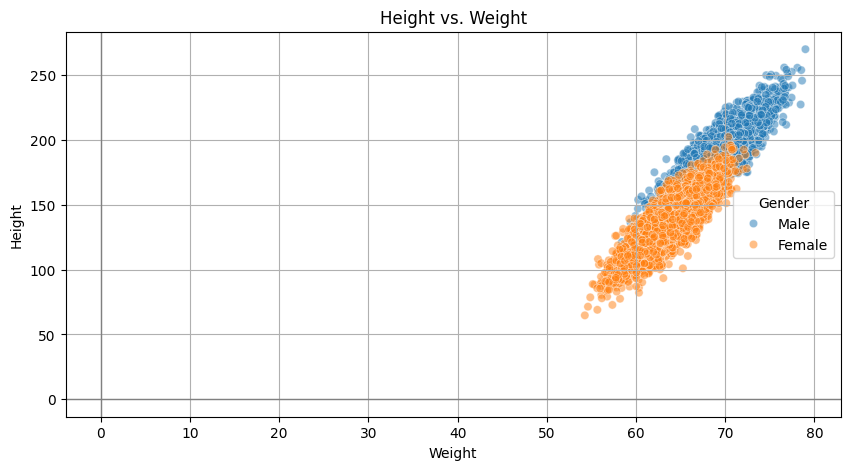

In [3]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Height', y='Weight', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


<a id="1-1"></a>
### Centering

In [4]:
mean_height = data['Height'].mean()
mean_weight = data['Weight'].mean()

data['Height_centered'] = data['Height'] - mean_height
data['Weight_centered'] = data['Weight'] - mean_weight

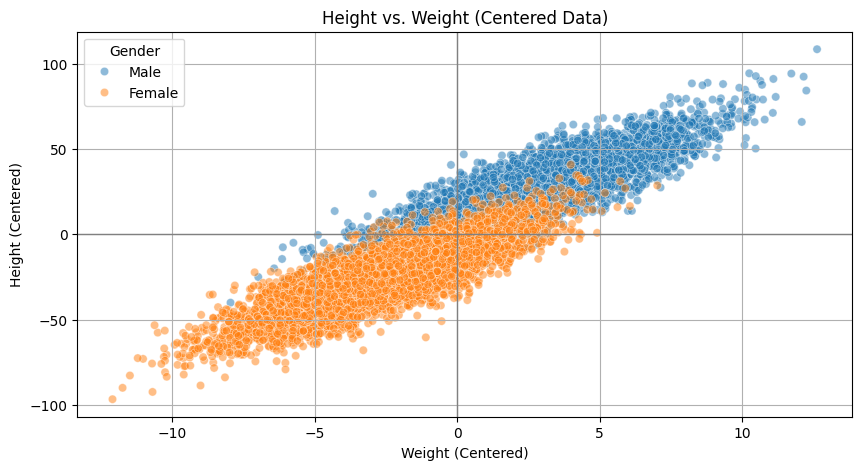

In [5]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Height_centered', y='Weight_centered', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight (Centered Data)')
plt.xlabel('Weight (Centered)')
plt.ylabel('Height (Centered)')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


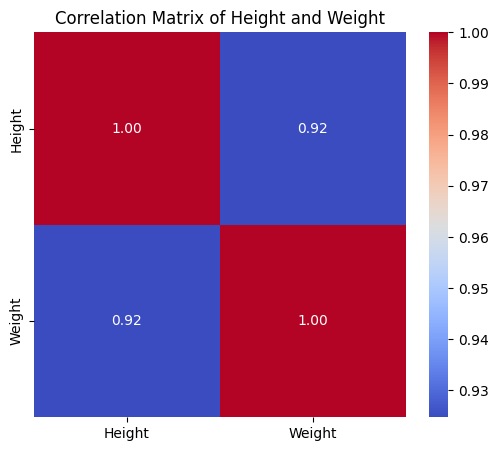

In [6]:
correlation_matrix = data[['Height', 'Weight']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Height and Weight')
plt.show()


<a id="1-2"></a>
### 1-2.Normalization

Text(0.5, 0, 'Weight (Min-Max Normalized)')

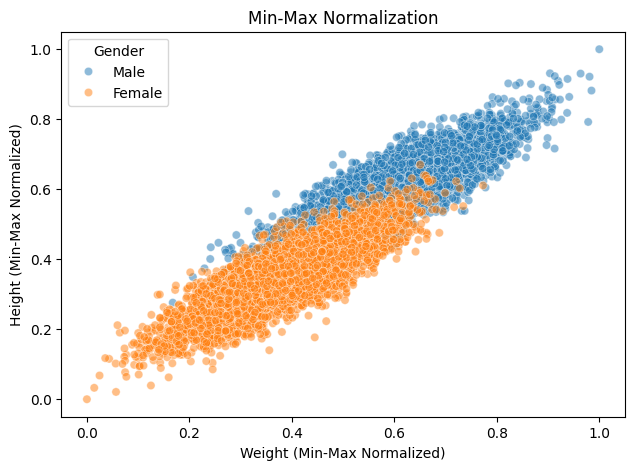

In [7]:
data['Height_min_max'] = (data['Height'] - data['Height'].min()) / (data['Height'].max() - data['Height'].min())
data['Weight_min_max'] = (data['Weight'] - data['Weight'].min()) / (data['Weight'].max() - data['Weight'].min())

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Height_min_max', y='Weight_min_max', data=data, hue='Gender', alpha=0.5)
plt.title('Min-Max Normalization')
plt.ylabel('Height (Min-Max Normalized)')
plt.xlabel('Weight (Min-Max Normalized)')

<a id="2"></a>
## 2. Weight Initialization

<a id="2-1"></a>
### 2-1. 0으로 초기화

In [8]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [9]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.zeros((input_size, layer_widths[0]))] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.zeros((layer_widths[i], layer_widths[i+1]))
            self.weights.append(weight)

        self.weights += [np.zeros((layer_widths[i], 1))] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net)) ## sigmoid -> relu

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

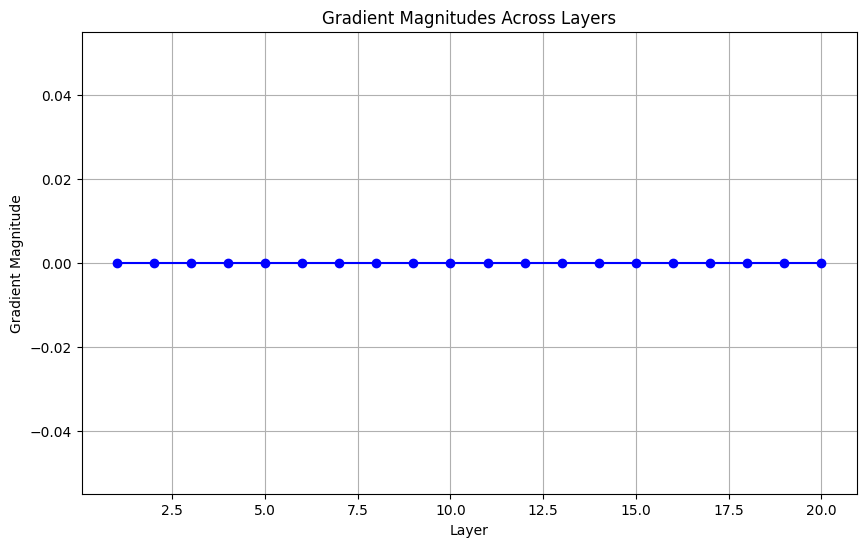

In [10]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="2-2"></a>
### 2-2. Random Initialization

먼저, 평균이 0이고 표준편차가 0.01인 정규분포를 따르는 random weight를 사용해서 테스트.

In [11]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0]) * 0.01]

        for i in range(self.layers - 1):
            weight = np.random.randn(layer_widths[i], layer_widths[i+1]) * 0.01 
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1) * 0.01]

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y]
        
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1])
            gradients.append(np.dot(activations[i].T, delta))
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

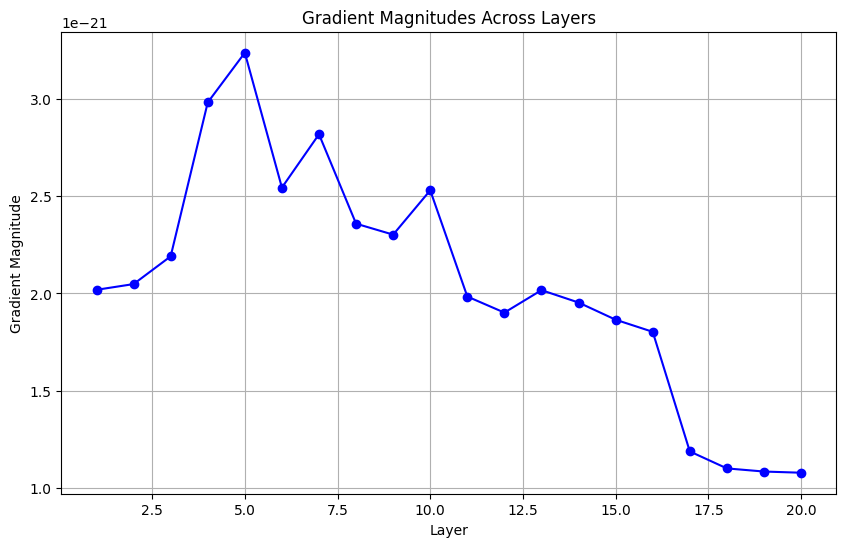

In [12]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

In [13]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0]) * 100]

        for i in range(self.layers - 1):
            weight = np.random.randn(layer_widths[i], layer_widths[i+1]) * 100
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1) * 100]

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y]
        
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1])
            gradients.append(np.dot(activations[i].T, delta))
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

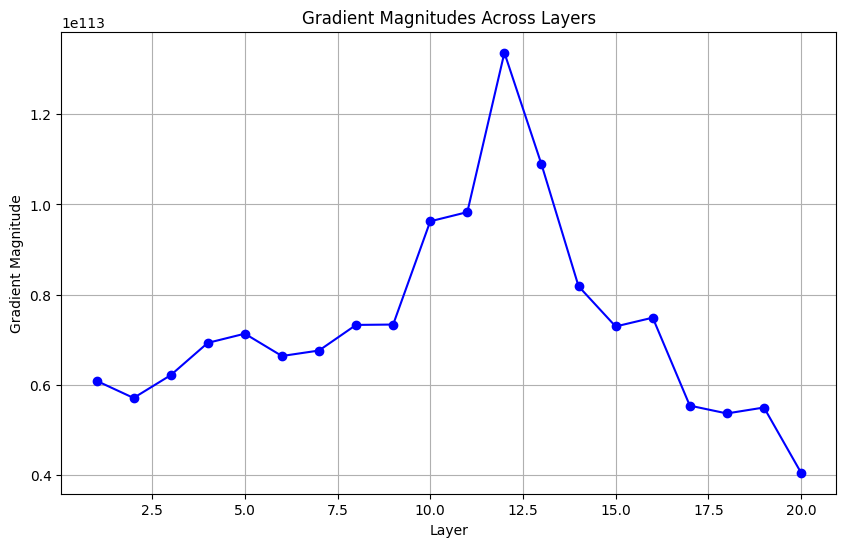

In [14]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="3"></a>
## 3. Xavier Initialization

In [15]:
input_size = 5
layer_depths = 3
layer_widths = [4, 4, 3]

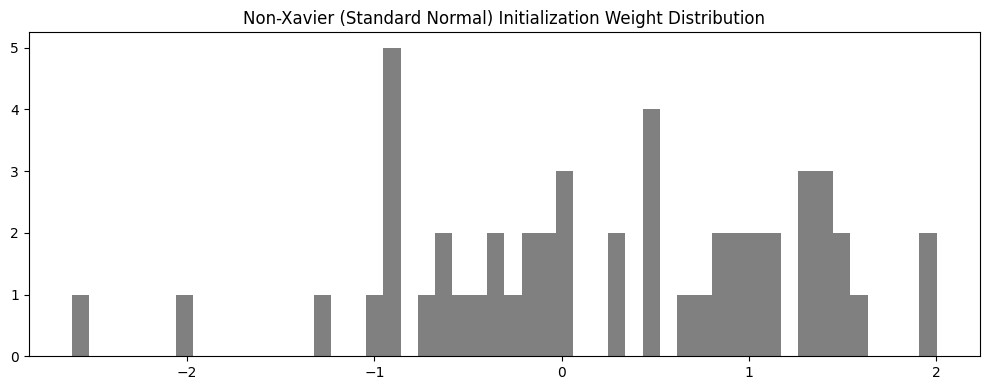

In [16]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = []

        # Non-Xavier initialization (standard normal distribution)
        for i in range(self.layers):
            if i == 0: # First hidden layer
                shape = (input_size, layer_widths[0])
            else: # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])
            weight = np.random.randn(*shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else: # If no hidden layers
            shape = (input_size, 1)
        weight = np.random.randn(*shape)
        self.weights.append(weight)

# Generate data for plots
nn_non_xavier = SimpleNeuralNetwork(input_size, layer_depths, layer_widths)

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))

# Non-Xavier distribution weights
all_weights_non_xavier = np.concatenate([w.flatten() for w in nn_non_xavier.weights])
ax.hist(all_weights_non_xavier, bins=50, color='gray')
ax.set_title('Non-Xavier (Standard Normal) Initialization Weight Distribution')

plt.tight_layout()
plt.show()


In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def xavier_uniform(shape, gain=1):
    fan_in, fan_out = shape[0], shape[1]
    limit = gain * np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=shape)

def xavier_normal(shape, gain=1):
    fan_in, fan_out = shape[0], shape[1]
    std = gain * np.sqrt(2 / (fan_in + fan_out))
    return np.random.normal(0, std, size=shape)

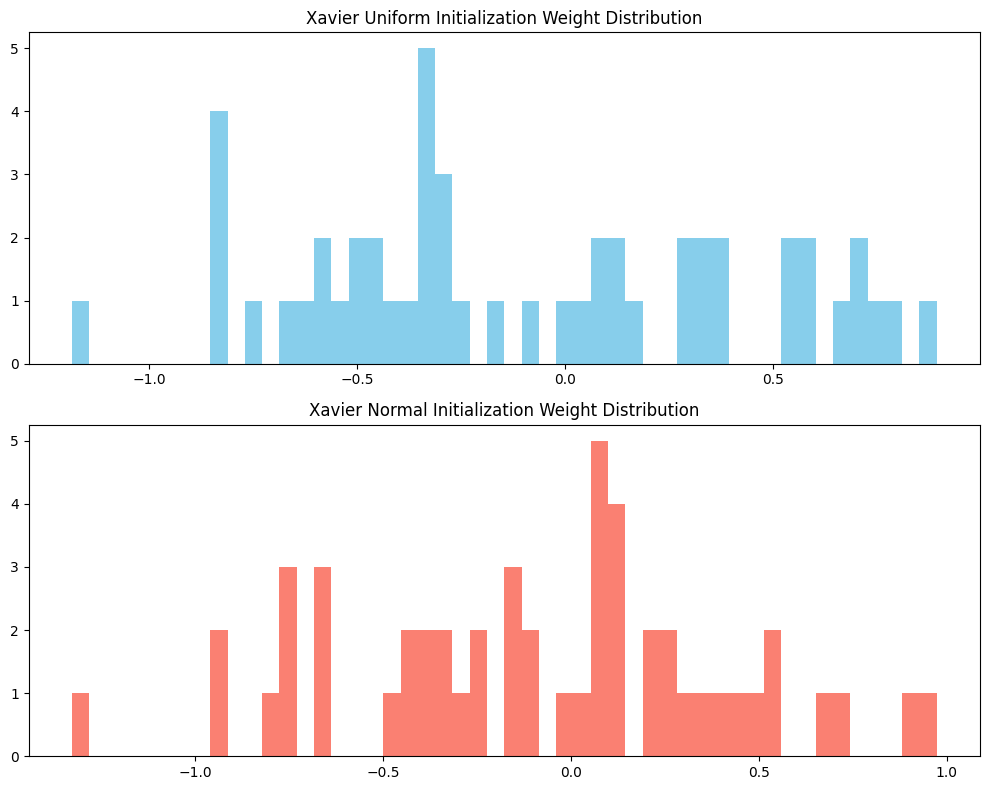

In [18]:
class SimpleNeuralNetworkXavier:
    def __init__(self, input_size, layer_depths, layer_widths, init_type='uniform'):
        self.layers = layer_depths
        self.weights = []
        self.init_type = init_type

        # Xavier initialization
        for i in range(self.layers):
            if i == 0: # First hidden layer
                shape = (input_size, layer_widths[0])
            else: # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])

            if init_type == 'uniform':
                weight = xavier_uniform(shape)
            else: # normal
                weight = xavier_normal(shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else: # If no hidden layers
            shape = (input_size, 1)
        
        if init_type == 'uniform':
            weight = xavier_uniform(shape)
        else: # normal
            weight = xavier_normal(shape)
        self.weights.append(weight)

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")


nn_uniform = SimpleNeuralNetworkXavier(input_size, layer_depths, layer_widths, 'uniform')
nn_normal = SimpleNeuralNetworkXavier(input_size, layer_depths, layer_widths, 'normal')

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
all_weights_uniform = np.concatenate([w.flatten() for w in nn_uniform.weights])
axes[0].hist(all_weights_uniform, bins=50, color='skyblue')
axes[0].set_title('Xavier Uniform Initialization Weight Distribution')

all_weights_normal = np.concatenate([w.flatten() for w in nn_normal.weights])
axes[1].hist(all_weights_normal, bins=50, color='salmon')
axes[1].set_title('Xavier Normal Initialization Weight Distribution')

plt.tight_layout()
plt.show()


[1.Data Preprocessing](#1)
  - [1-1.Centering](#1-1)
  - [1-2.Normalization](#1-2)

[2.Weight Initialization](#2)
  - [2-1. 0으로 초기화](#2-1)
  - [2-2. Random Initialization](#2-2)

[3. Xavier Initialization](#3)

[4. He Initialization](#4)

<a id="4"></a>
## 4. He Initialization

In [19]:
input_size = 5
layer_depths = 3
layer_widths = [4, 4, 3]

In [20]:
class SimpleNeuralNetworkHe:
    def __init__(self, input_size, layer_depths, layer_widths, init_type='normal'):
        self.layers = layer_depths
        self.weights = []
        self.init_type = init_type

        # He initialization
        for i in range(self.layers):
            if i == 0:  # First hidden layer
                shape = (input_size, layer_widths[0])
            else:  # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])

            if init_type == 'uniform':
                weight = self.he_uniform(shape)
            else:  # normal
                weight = self.he_normal(shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else:  # If no hidden layers
            shape = (input_size, 1)

        if init_type == 'uniform':
            weight = self.he_uniform(shape)
        else:  # normal
            weight = self.he_normal(shape)
        self.weights.append(weight)

    def he_normal(self, shape):
        std = np.sqrt(2. / shape[0])  # fan_in
        return np.random.normal(0, std, size=shape)

    def he_uniform(self, shape):
        limit = np.sqrt(6. / shape[0])  # fan_in
        return np.random.uniform(-limit, limit, size=shape)

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

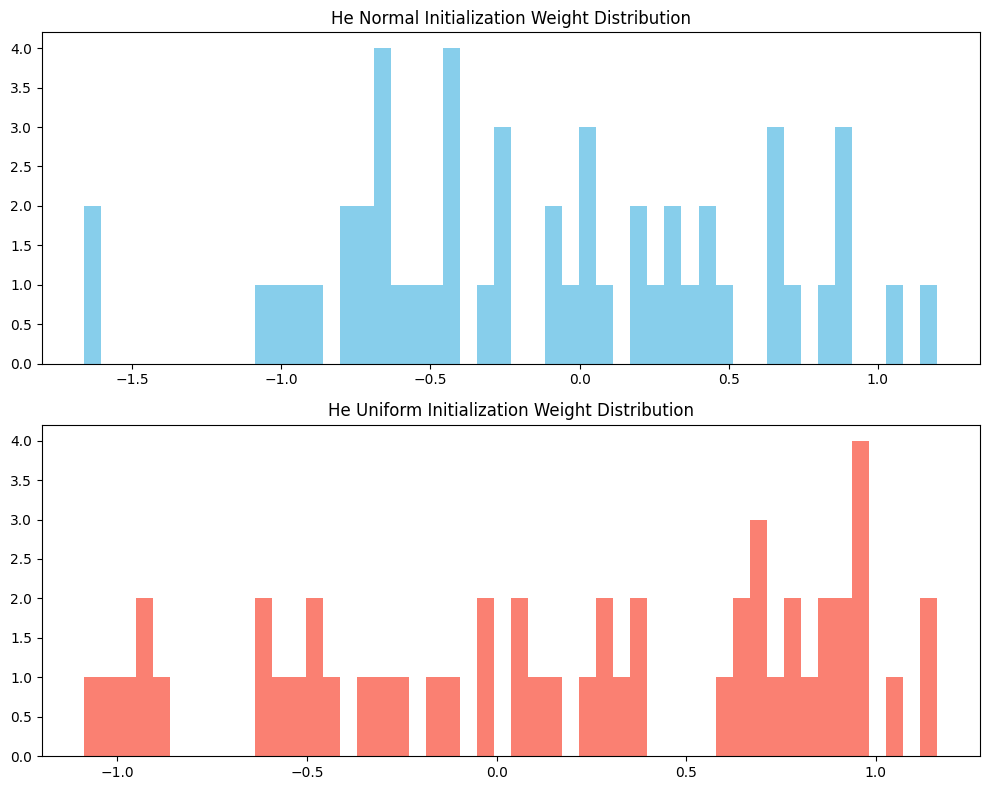

In [21]:
nn_he_normal = SimpleNeuralNetworkHe(input_size, layer_depths, layer_widths, 'normal')
nn_he_uniform = SimpleNeuralNetworkHe(input_size, layer_depths, layer_widths, 'uniform')

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
all_weights_he_normal = np.concatenate([w.flatten() for w in nn_he_normal.weights])
axes[0].hist(all_weights_he_normal, bins=50, color='skyblue')
axes[0].set_title('He Normal Initialization Weight Distribution')

all_weights_he_uniform = np.concatenate([w.flatten() for w in nn_he_uniform.weights])
axes[1].hist(all_weights_he_uniform, bins=50, color='salmon')
axes[1].set_title('He Uniform Initialization Weight Distribution')

plt.tight_layout()
plt.show()


In [22]:
from tqdm import tqdm
from utils.data_utils import download_and_extract_mnist_data

In [23]:
data_dir = "/home/pervinco/Datasets/MNIST"

train_x, train_y, test_x, test_y = download_and_extract_mnist_data(data_dir)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print(train_x.shape, test_x.shape)

train_y = np.where(train_y == 7, 1, 0)
test_y = np.where(test_y == 7, 1, 0)

train_y = np.expand_dims(train_y, axis=0)
test_y = np.expand_dims(test_y, axis=0)
print(train_y.shape, test_y.shape)

classes = np.unique(train_y)
print(classes)

MNIST data is already downloaded and extracted.
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(784, 60000) (784, 10000)
(1, 60000) (1, 10000)
[0 1]


In [24]:
epochs = 10
batch_size = 64
learning_rate = 0.2

train_x = train_x / 255.0
test_x = test_x / 255.0

In [25]:
depth = 5
unit_list = [512] * depth

In [26]:
def initialize_weights(input_dim, output_dim, init_type='he'):
    if init_type == 'he':
        weights = np.random.randn(output_dim, input_dim) * np.sqrt(2. / input_dim)
    elif init_type == 'xavier':
        limit = np.sqrt(6. / (input_dim + output_dim))
        weights = np.random.uniform(-limit, limit, (output_dim, input_dim))
    else:
        raise ValueError("Invalid initialization type. Choose 'he' or 'xavier'.")
    
    bias = np.zeros((output_dim, 1))  # Bias initialization remains the same.
    return {'weights': weights, 'bias': bias}

def linear_layer(input_dim, output_dim, init_type='he'):
    return initialize_weights(input_dim, output_dim, init_type)


layers = []
input_dim = train_x.shape[0]  # 첫 번째 층의 입력 차원
for idx in range(depth):
    if idx == 0:
        output_dim = unit_list[idx]
    else:
        output_dim = unit_list[idx] if idx < depth - 1 else len(classes)
    layers.append(linear_layer(input_dim, output_dim))
    input_dim = output_dim  # 다음 층의 입력 차원을 현재 층의 출력 차원으로 업데이트


In [27]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return bce

In [28]:
def forward_propagation(X, layers):
    activations = [X]  # 입력층의 활성화 결과는 입력 데이터 X.
    for layer in layers:
        W = layer['weights']
        b = layer['bias']
        Z = np.dot(W, activations[-1]) + b
        A = sigmoid(Z)
        # if layer is not layers[-1]:  # 출력층이 아닌 경우 소프트맥스 활성화 함수 적용
        #     A = relu(Z)
        # else:  # 출력층인 경우 소프트맥스 활성화 함수 적용
        #     A = softmax(Z)
        activations.append(A)

    return activations


In [29]:
def backward_propagation(X, Y, activations, layers, learning_rate):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # 가중치와 편향 업데이트
        layers[i]['weights'] -= learning_rate * dW
        layers[i]['bias'] -= learning_rate * db
        gradients.append((dW, db))
    
    return layers, gradients


In [30]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = binary_cross_entropy(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [31]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/10, Loss: 0.3367


Epoch 2/10, Loss: 0.3347


Epoch 3/10, Loss: 0.3331


Epoch 4/10, Loss: 0.3298


Epoch 5/10, Loss: 0.3182


Epoch 6/10, Loss: 0.1920


Epoch 7/10, Loss: 0.0794


Epoch 8/10, Loss: 0.0662


Epoch 9/10, Loss: 0.0612


Epoch 10/10, Loss: 0.0585
